# Bias vs Variance in Linear Regression

This notebook contains the Programming Exercise 5 of the Andrew Ng's course on Coursera.

In this exercise we will implement a Regularized Linear Regression model and evaluate it applying some machine learning diagnostics to examine the bias vs variance effect.

We will be predicting the amount of water flowing out of a dam using the change of water level in a reservoir. It is a rather simple data set (just a single feature), so we will be able to visualize the fitting in 2D plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [124]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('ex5data1.mat')

# Training set
Xtr = data['X']
ytr = data['y']

# Cross validation set
Xcv = data['Xval']
ycv = data['yval']

# Test set
Xtest = data['Xtest']
ytest = data['ytest']

print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


The training set contains less samples (12) than the cv and the test (21). I guess it is prepared this way to find some over-fitting problems during the exercise.

## Explore data

In [125]:
# Plot scatter 
def plotScatter(x,y,title,x_title,y_title):
    plt.figure(figsize=(6,4))
    plt.plot(x, y, 'go')
    plt.grid(True)
    plt.title(title)
    plt.ylabel(x_title)
    plt.xlabel(y_title)

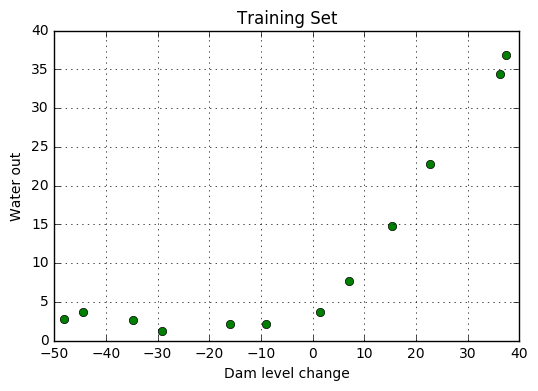

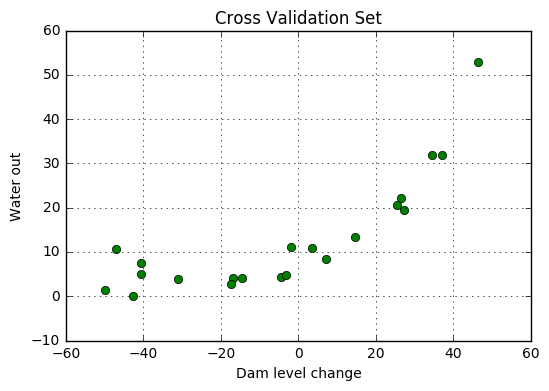

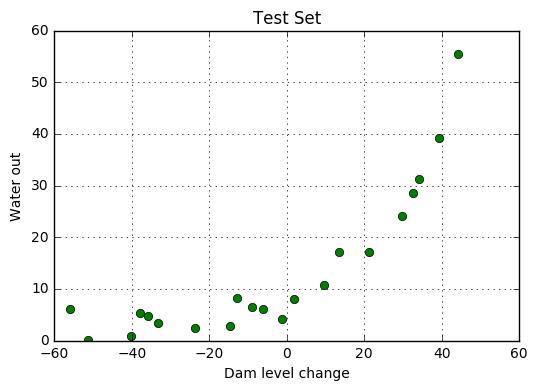

In [126]:
plotScatter(Xtr,ytr,'Training Set','Water out','Dam level change')
plotScatter(Xcv,ycv,'Cross Validation Set','Water out','Dam level change')
plotScatter(Xtest,ytest,'Test Set','Water out','Dam level change')

## Regularized Linear Regression Model

In [94]:
# function to compute h(x)
def h(X, theta):
    return X*theta.T

# function to compute the cost of the entire set as (1/2m)SUM((X·theta'-y)^2) + regularization
def computeCost(theta, X, y, lmbda):
    
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    insides = np.power(h(X, theta) - y, 2) # vector with all insides values
    
    reg = lmbda/(2*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2)) # all thetas except theta[0]

    return np.sum(insides)/(2*len(X)) + reg

In [98]:
# function that computes the gradient for each theta parameter (single step, not the gradient algorithm)
def computeGradient(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    # init vars
    num_parameters = int(theta.ravel().shape[1])
    gradient = np.zeros(num_parameters)
       
    # compute gradient for each parameter theta
    for i in range(num_parameters):
        term = np.multiply(h(X, theta) - y, X[:,i])
        if (i == 0):
            gradient[i] = np.sum(term) / len(X)
        else:
            gradient[i] = (np.sum(term) / len(X)) + ((lmbda / len(X)) * theta[:,i])
    
    return gradient

In [127]:
# insert 'ones' column in X matrices
Xtr   = np.insert(Xtr  ,0,1,axis=1)
Xcv   = np.insert(Xcv  ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)
print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 2) (12, 1)
(21, 2) (21, 1)
(21, 2) (21, 1)


In [128]:
# set theta starting values (theta0, theta1) initilaized to (0,0)
thetaStart = np.zeros(Xtr.shape[1],dtype=np.float)
print(thetaStart.shape)

(2,)


In [129]:
# Compute the cost with thetaStart = (0,0) (should be around 140.95...)
computeCost(thetaStart, Xtr, ytr, 0)

140.95412088055392

In [130]:
# Compute the gradient with thetaStart = (0,0) (should be around [-11.21..., -245.65...)
computeGradient(thetaStart, Xtr, ytr, 0)

array([ -11.21758933, -245.65199649])

In [131]:
from scipy import optimize

# just a helper function to call scipy fmin optimzation function
def optimizeTheta(X, y, theta, lmbda):
    # using fmin_tnc (we need to pass gradient)
    result = optimize.fmin_tnc(func=computeCost, 
                               x0=theta, 
                               args=(X, y, lmbda), 
                               fprime=computeGradient)
    return result[0], computeCost(result[0], X, y, lmbda)   
    
    # using minimize (no need to pass gradient)
    #result = optimize.minimize(computeCost, theta, args=(X, y, lmbda),  method='BFGS', options={"maxiter":500, "disp":False} )
    #return result.x, result.fun

In [132]:
# And optimize!
thetaFinal, minCost = optimizeTheta(Xtr, ytr, thetaStart, 0)
print(thetaFinal, minCost)

[ 13.08790351   0.36777923] 22.3739064951


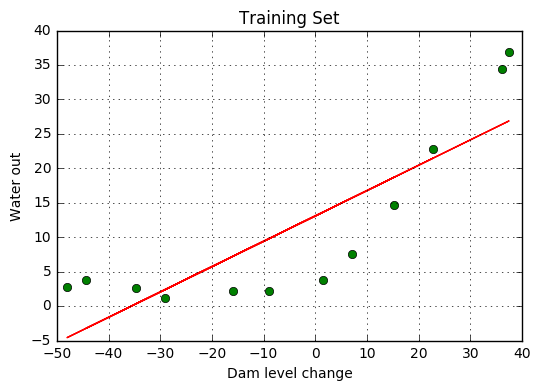

In [134]:
plotScatter(Xtr[:,1],ytr,'Training Set','Water out','Dam level change')
plt.plot(Xtr[:,1], thetaFinal[0] + thetaFinal[1]*Xtr[:,1], 'r-')